In [7]:
from matplotlib import pyplot as plt
import matplotlib
import numpy
from matplotlib import gridspec
import utils
import xarray
import warnings
import pandas
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import string
import importlib
importlib.reload(utils)
import gsw
warnings.filterwarnings('ignore')
import importlib # to be able to reload user modules with importlib.reload(utils)
importlib.reload(utils)

#df, profiles = utils.create_dataframe(pfloat='5904471_Mprof.nc', force_reconstruction=False)
#df_col = xarray.open_dataset('../data/collocation_5904471_Mprof.nc'); #title='300234067208900'

df, profiles = utils.create_dataframe(pfloat='300234067208900.nc', force_reconstruction=False)
df_col = xarray.open_dataset('../data/collocation_300234067208900.nc'); title='300234067208900'

#df, profiles = utils.create_dataframe(pfloat='300234068638900.nc', force_reconstruction=False)
#df_col = xarray.open_dataset('../data/collocation_300234068638900.nc'); title='300234068638900.nc'

Returning previously computed DataFrame...


In [10]:
normdict = dict(
    depth_topo=matplotlib.colors.Normalize(vmin=-4500.0, vmax=-2500.0),
    slope=matplotlib.colors.Normalize(vmin=0, vmax=50),
    longitude=matplotlib.colors.Normalize(vmin=0, vmax=200),#6),
    latitude=matplotlib.colors.Normalize(vmin=-67, vmax=-63.5))
cmapdict = dict(
    depth_topo=plt.cm.coolwarm_r,
    slope=plt.cm.Greys,
    longitude=plt.cm.cividis,
    latitude=plt.cm.cividis)


def profile_colors(profiles, df_col, condition):
    # condition can be: slope, depth, longitude, latitude
    # define facecolors of the profiles or scatters
    results = []
    df_col['slope'] = numpy.sqrt(df_col['depth_topo_gradx']**2+df_col['depth_topo_grady']**2)
    norm = normdict[condition]
    for pindex,profile in enumerate(profiles):
        resultsdict = dict(index=pindex, color=None, zorder=None)
        #resultsdict['index']=pindex
        #value = df_col.sel(expver=5).isel(time=10)[condition]
        try:
            value = df_col.sel(time=profile.iloc[0].dates.to_pydatetime())[condition]
        except:
            # print('missing out one profile')
            resultsdict['color']='lightgrey'#colors.append('lightgrey')
            resultsdict['zorder']=-1#zorders.append(-1)
            continue
        rgba = cmapdict[condition](normdict[condition](value))
        resultsdict['color']=rgba#colors.append(rgba)
        #indices.append(index)
        resultsdict['zorder']=1#zorders.append(1)
        #print(resultsdict)
        results.append(resultsdict)
    return pandas.DataFrame(results).set_index('index')#results#colors, zorders, indices

def profile_threshold_colors(profiles, df_col, condition, key):
    # define edgecolors, e.g. for rms mixing profiles
    
    # differentiate between SOCCOM and our floats, to equalize vertical resolution later on in 
    # 'compute_diapycnal_spice_variations'
    if key in ['300234067208900.nc', '300234068638900.nc']:
        SOCCOM=False #rmslimit=5000
    else:
        SOCCOM=True#rmslimit=100
    rmslimit=5000
    results = []
    df_col['slope'] = numpy.sqrt(df_col['depth_topo_gradx']**2+df_col['depth_topo_grady']**2)
    rmsdeep, indices, dates = utils.compute_diapycnal_spice_variations(
                                   profiles, 
                                   upperdepthlimit=500, 
                                   lowerdepthlimit=1550, 
                                   SOCCOM=SOCCOM)
    rms, indices, dates = utils.compute_diapycnal_spice_variations(
                                   profiles, 
                                   upperdepthlimit=250, 
                                   lowerdepthlimit=1550, 
                                   SOCCOM=SOCCOM)
    # breakpoint()
    dictionary = {'rms': rms, 'indices': indices, 'dates': dates}
    df = pandas.DataFrame(data=dictionary)
    df = df.set_index('indices')
   
    for pindex, profile in enumerate(profiles):
        resultsdict = dict(index=pindex, color=None, zorder=None)
        #print(pindex, indices)
        if not pindex in indices:
            # profile with too shallow maximum depth
            continue 
        try:
            depth = df_col.sel(time=profile.iloc[0].dates.to_pydatetime()).depth_topo
            topoy = df_col.sel(time=profile.iloc[0].dates.to_pydatetime()).depth_topo_grady
            topox = df_col.sel(time=profile.iloc[0].dates.to_pydatetime()).depth_topo_gradx
            latitude = df_col.sel(time=profile.iloc[0].dates.to_pydatetime()).latitude
            longitude = df_col.sel(time=profile.iloc[0].dates.to_pydatetime()).longitude
        except:
            results.append(resultsdict)
            continue
            
        #breakpoint()
        # shallow (0-500m profile - continue)
        if max(abs(profile['pre'])) < 700:
            results.append(resultsdict)
            continue 
            
        if condition in ['longitude', 'latitude', 'depth_topo', 'slope']:
            try:
                value = df_col.sel(time=profile.iloc[0].dates.to_pydatetime())[condition]
            except:
                # print('missing out one profile')
                resultsdict['color']='lightgrey'#colors.append('lightgrey')
                resultsdict['zorder']=-1#zorders.append(-1)
                continue
            rgba = cmapdict[condition](normdict[condition](value))
            resultsdict['color']=rgba#colors.append(rgba)
            #indices.append(index)
            resultsdict['zorder']=1#zorders.append(1)
            #print(resultsdict)
            #results.append(resultsdict)
        # breakpoint()
        if condition == 'rms':
            if pindex == 0:
                # first profile is often noisy/wrong
                results.append(resultsdict)
                continue
            try:
                if df.loc[pindex]['rms']>rmslimit:#rms[pindex]>rmslimit:
                    # print('decided for red color due to rms=%s'%rms[pindex])
                    resultsdict['color']='red'
                    resultsdict['zorder']=4
                else:
                    resultsdict['color']=None
                    resultsdict['zorder']=3
            except:
                breakpoint()
                #print('skipped one profile due to undefined rms')
                
        if condition == 'floatkey':
            resultsdict['color']=filenames[key]#[filenames[key]*len(df_col)]
            
        if condition == 'region':
            boxes = [dict(x=2.05, y=-64.7, w=5, h=2, color='black', zorder=2),
                     dict(x=-2.5, y=-67, w=4.5, h=4, color='tab:green', zorder=3),
                     dict(x=2.05, y=-67, w=5, h=2.25, color='orange', zorder=2)]
            #for element in df_col:
            #    breakpoint()
            #    latitude = element.latitude
            #    longitude = element.longitude
            resultsdict['color'] = 'lightgrey' # this is the scatter outside of all boxes
            for box in boxes:
                if ((longitude>box['x']) and (longitude<box['x']+box['w']) and
                    (latitude>box['y']) and (latitude<box['y']+box['h'])):
                     resultsdict['color']=box['color']
                     resultsdict['zorder']=box['zorder']
                if not resultsdict['color']:
                    resultsdict['color']='lightgrey'
        results.append(resultsdict)
    results = pandas.DataFrame(results).set_index('index')
    # breakpoint()
    return results#results#sdict#colors, zorders

filenames = {'300234067208900.nc':'blue',
             #'300234068638900.nc':'red',
             #'5904468_Mprof.nc':'orange', 
             #'5904471_Mprof.nc':'purple', 
             #'GL_PR_PF_5903616.nc':'brown',
             #'GL_PR_PF_7900640.nc':'green', 
             #'GL_PR_PF_5905382.nc':'olive',
             }

variables_dictionary = dict(tem='conservative temperature',
                           sal='absolute salinity',
                           den=r'potential density ($\sigma_0$)',
                           gamman='neutral density',
                           spice='spice')
units_dictionary = dict(tem='[°C]',
                        sal='[g/kg]',
                        den='[kg/m³]',
                        gamman='[kg/m³]',
                        spice='[kg/m³]')

def plot_colored_figure(years, months, filenames, variables, mode, colorby, edgecolorby, comparedepth, axs):
    # mode should by either scatter or profile 
    #years = year#numpy.arange(2018,2020,1)#[2015,2016,2017,2018,2019,2020,2021]#,2017,2018,2019]#2018,2019,2020]
    #months = [1,2,3,4,5,6,7,8,9,10,11,12]
    for key in filenames.keys():
        df, profiles = utils.create_dataframe(pfloat=key, force_reconstruction=False)
        df_col = xarray.open_dataset('../data/collocation_%s'%key)
        title=key
        results = profile_threshold_colors(profiles, df_col, colorby, key)#'latitude')
        threshold_results = profile_threshold_colors(profiles, df_col, edgecolorby, key)
        for index, variable in enumerate(variables):#['tem', 'sal', 'den', 'spice']):
            #breakpoint()
            #for pindex, profile in enumerate(profiles):
            #breakpoint()
            for pindex in results.index:
                profile = profiles[pindex]
                
                if pindex == 0:
                    # first profile is often noisy/wrong
                    continue
                if len(profile)==0:
                    continue
                profile['spice'] = gsw.spiciness0(profile['sal'], profile['tem'])
                if (profile.iloc[0].dates.year in years) and (
                    profile.iloc[0].dates.month in months):
                    try:
                        depth = df_col.sel(time=profile.iloc[0].dates.to_pydatetime()).depth_topo
                    except:
                        continue

                    if mode == 'profile':
                        axs[index].plot(profile[variable], profile['pre'], 
                                        color=results.loc[pindex]['color'], alpha=0.5, 
                                        zorder=results.loc[pindex]['zorder'])

                    else: # (mode == 'scatter')
                        comparedepth = comparedepth#350
                        where = 'at %sm depth'%comparedepth
                        if numpy.nanmin(profile['pre']+comparedepth) > 20:
                            # This profile has new value that is sufficiently close to 400m depth
                            print('sorted out profile in %s'%key)
                            continue
                        depthindex = numpy.argmin(abs(profile['pre']+comparedepth)) # depth index closest to the summand
                        #try:
                        edgecolor=threshold_results.loc[pindex]['color']
                        #except:
                        #    breakpoint()
                        if results.loc[pindex]['color'] == 'lightgrey':
                            continue
                        #if results.loc[pindex]['color'] == None:
                        #    print('skipped')
                        #    continue
                        if edgecolor=='red':
                            marker='*'
                            s=100 # markersize
                        else:
                            marker='o'
                            s=50 #markersize
                        # print(results)
                        axs[index].scatter(profile[variable].values[depthindex], depth, s=s,
                                           color=results.loc[pindex]['color'], zorder=results.loc[pindex]['zorder'],
                                           edgecolor=threshold_results.loc[pindex]['color'], marker=marker)
            if mode == 'scatter':
                axs[index].set_xlabel(units_dictionary[variable])
                axs[index].set_title(variables_dictionary[variable]+'\n'+where)

            #axs[index].grid(zorder=100)
        axs[0].set_ylabel('bathymetry depth at float location')
            #else:
                # This is in case the profile is not in the date range specified first
            #    axs[index].plot(profile[variable], profile['pre'], color='lightgrey', alpha=0.5, zorder=-2)

Returning previously computed DataFrame...
Returning previously computed DataFrame...
Returning previously computed DataFrame...
Returning previously computed DataFrame...
Returning previously computed DataFrame...
Returning previously computed DataFrame...
Returning previously computed DataFrame...
Maybe asking Chscherbina for advice about the high sp curvature values also


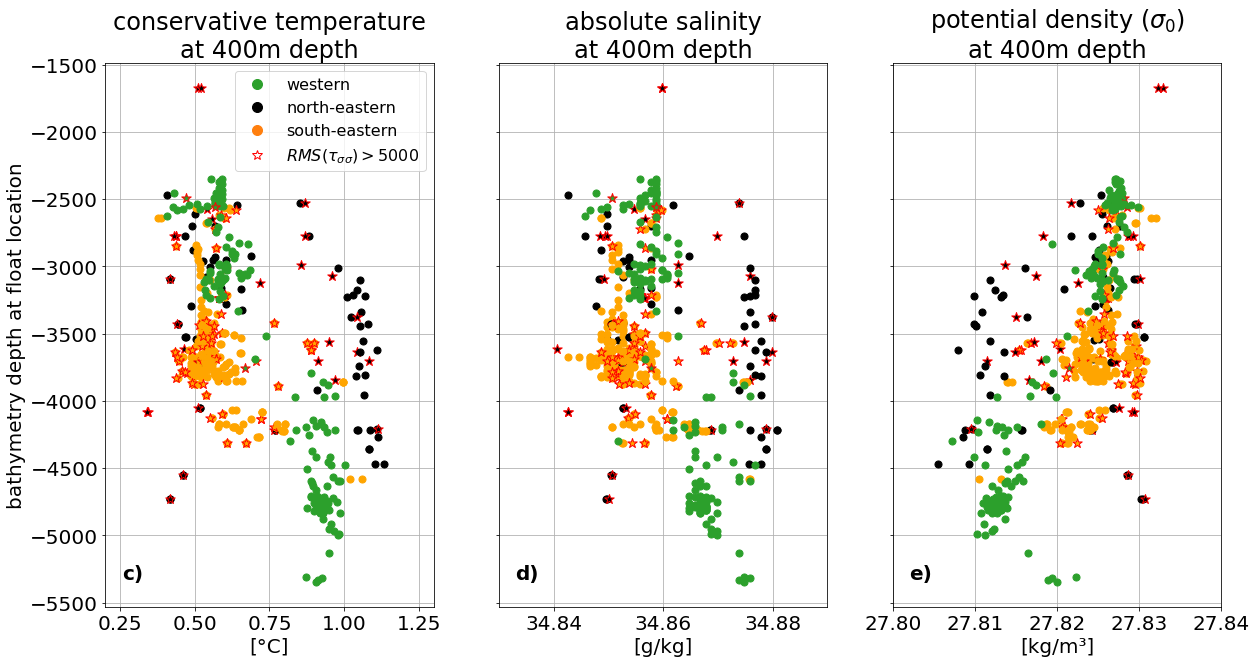

In [11]:

comparedepth = 400
    
plt.rc('font', size=20)
fig, axs = plt.subplots(nrows=1, ncols=3, gridspec_kw={'width_ratios':[5,5,5], 'hspace':0.1}, figsize=[20,10])#, sharey=True)
years = numpy.arange(2018,2022,1)
months = numpy.arange(1,13,1)

filenames = {'300234067208900.nc':'blue',
             '300234068638900.nc':'red',
             '5904468_Mprof.nc':'orange', 
             '5904471_Mprof.nc':'purple', 
             'GL_PR_PF_5903616.nc':'brown',
             'GL_PR_PF_7900640.nc':'green', 
             'GL_PR_PF_5905382.nc':'olive',}

#filenames = {'300234067208900.nc':'blue',}

variables = ['tem', 'sal', 'den']
colorby='region'
edgecolorby='rms'

plot_colored_figure(years=years, months=months, filenames=filenames, 
                variables=variables, mode='scatter', colorby=colorby, 
                edgecolorby=edgecolorby, comparedepth=comparedepth,
                axs=axs)
axs[1].set_yticklabels([])
axs[2].set_yticklabels([])

axs[0].set_xlim(0.2,1.3)
axs[1].set_xlim(34.83,34.89)
axs[2].set_xlim(27.8,27.84)

for n, ax in enumerate(axs[0:3]): 
    ax.text(0.05, 0.05, string.ascii_lowercase[n+2]+')', transform=ax.transAxes, 
            size=20, weight='bold')
    ax.grid()
    
blue_dot = mlines.Line2D([], [], color='tab:green', marker='o', linestyle='None',
                          markersize=10, label='western')
black_dot = mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                          markersize=10, label='north-eastern')
orange_dot = mlines.Line2D([], [], color='tab:orange', marker='o', linestyle='None',
                          markersize=10, label='south-eastern')
red_star = mlines.Line2D([], [], color='white', markeredgecolor='red', marker='*', linestyle='None',
                          markersize=10, label=r'$RMS(\tau_{\sigma \sigma})>5000$')
axs[0].legend(handles=[blue_dot, black_dot, orange_dot, red_star], fontsize=16)

print('Maybe asking Chscherbina for advice about the high sp curvature values also')
plt.savefig('../plots/figures/figure5.png', dpi=200)
plt.show()

In [ ]:
# the following is going to be a prototype for subsampling. It is not needed for the original plotting process.

df2, profiles2 = utils.create_dataframe(pfloat='5904471_Mprof.nc', force_reconstruction=False)
df_col2 = xarray.open_dataset('../data/collocation_5904471_Mprof.nc'); #title='300234067208900'

df, profiles = utils.create_dataframe(pfloat='300234067208900.nc', force_reconstruction=False)
df_col = xarray.open_dataset('../data/collocation_300234067208900.nc'); title='300234067208900'

In [82]:
# Explanation of subsampling function:
# The ARGO/SOCCOM data is sampled in 2m intervals to a depth of 1000m,
# while our data is sampled in 25m intervals there. The ARGO/SOCCOM data
# is sampled in 100m intervals below 1000m, while our data is sampled with
# 25m there. We subsample the foreign data to make the rms analysis comparable
profile_upper1000 = profiles2[10][profiles2[10].pre>-1000].iloc[0::12]
profile_lower1000 = profiles2[10][profiles2[10].pre<-1000]
profile = pandas.concat([profile_upper1000, profile_lower1000], axis=0)
len(profiles[10])

198

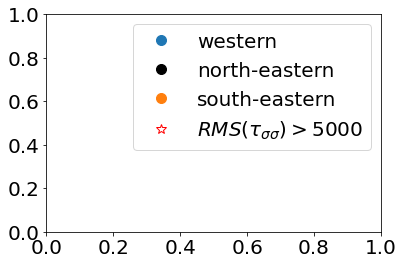

In [11]:
#red_patch = mpatches.Patch(color='tab:orange', label='The red data')
#blue_patch = mpatches.Patch(color='tab:blue', label='The blue data')
#black_patch = mpatches.Patch(color='k', label='The black data')
blue_dot = mlines.Line2D([], [], color='tab:blue', marker='o', linestyle='None',
                          markersize=10, label='western')
black_dot = mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                          markersize=10, label='north-eastern')
orange_dot = mlines.Line2D([], [], color='tab:orange', marker='o', linestyle='None',
                          markersize=10, label='south-eastern')
red_star = mlines.Line2D([], [], color='white', markeredgecolor='red', marker='*', linestyle='None',
                          markersize=10, label=r'$RMS(\tau_{\sigma \sigma})>5000$')
plt.legend(handles=[blue_dot, black_dot, orange_dot, red_star])

In [12]:
profile = numpy.array([1,2,3,numpy.nan,numpy.nan, 6,7,8])
#profile = numpy.array([1,2,3,4,5,6,7,8])
numpy.nanargmin(abs(profile-5))

5